In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pysal as ps
import seaborn as sns
from matplotlib import colors
import pylab as pl
%pylab inline
from matplotlib.colors import ListedColormap

Populating the interactive namespace from numpy and matplotlib


In [3]:
gdf = gpd.read_file("homeless311_cT_1316/homeless311_ct_1316.shp")
#gdf.info(null_counts=True)
boro = gdf.BoroName.unique()
boro = boro.astype(str)
gdf = gdf.loc[:, ['BoroCT2010', 'BoroName', 'Count_', 'geometry']]
gdf.head(2)

,BoroCT2010,BoroName,Count_,geometry
0,5000900,Staten Island,8,"POLYGON ((962269.1260375977 173705.5001831204,..."
1,5007400,Staten Island,1,"POLYGON ((967656.8290405422 155637.1314087063,..."


In [4]:
gdf = gdf.to_crs(epsg=2263) #http://www.spatialreference.org/ref/epsg/nad83-new-york-long-island-ftus/

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


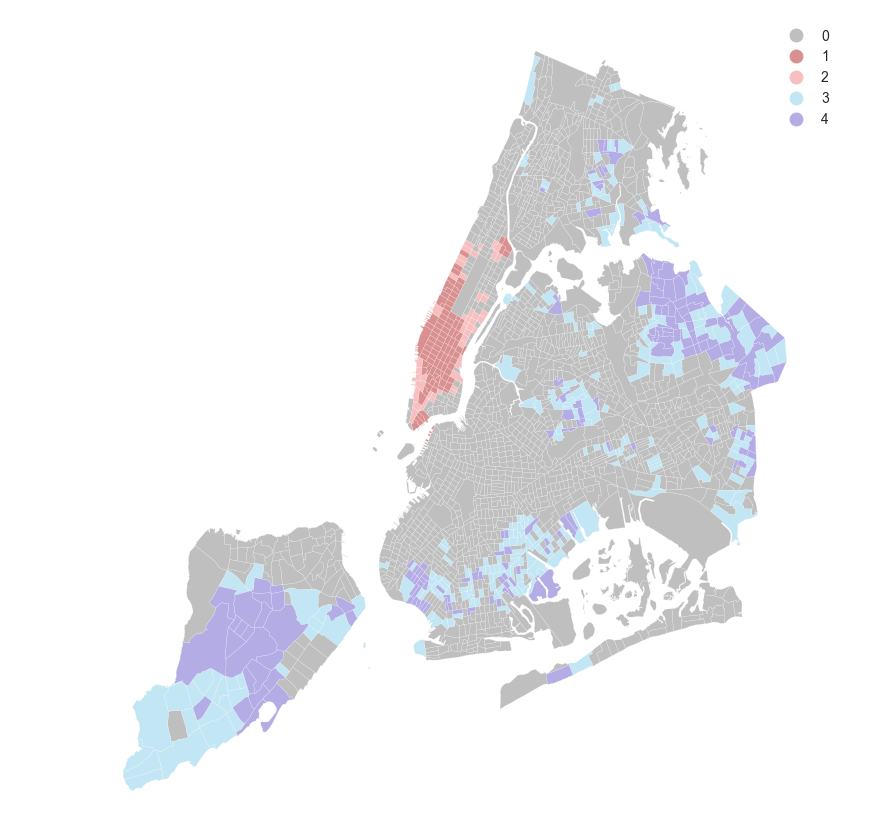

In [5]:
z=gdf.copy()
z.to_file("temp")
#zone = ps.queen_from_shapefile("temp/temp.shp")
zone = ps.knnW_from_shapefile("temp/temp.shp", 5)
zone.transform ='r'
spatialLag = ps.lag_spatial(zone, z.Count_)
z['SpatialLag'] = spatialLag
col = 'Count_'
LISA = ps.Moran_Local(z[col] , zone, permutations=9999)
z['Part'] = LISA.q
z['sig0.01'] = LISA.p_sim < 0.01
z['sig0.05'] = LISA.p_sim < 0.05
z['Hot0.01'] = (z['Part'] == 1 * z['sig0.01'])
z['Cold0.01'] = (z['Part'] == 3 * z['sig0.01'])
z['Hot0.05'] = (z['Part'] == 1 * ((~(z['sig0.01'])) & (z['sig0.05'])))
z['Cold0.05'] = (z['Part'] == 3 * ((~(z['sig0.01'])) & (z['sig0.05'])))
hcmap = ListedColormap(['grey','FireBrick','LightCoral','SkyBlue','SlateBlue'])
hotcold = z['Hot0.01']*1 + z['Hot0.05']*2 + z['Cold0.05']*3 + z['Cold0.01'] *4
z['hotcold']=hotcold
f, ax = pl.subplots(1,1,figsize=(10,10))
z.assign(c=hotcold).plot(column='c', categorical=True, \
                                      cmap=hcmap, linewidth=0.1, ax=ax, \
                                      edgecolor='white', legend=True)
ax.set_axis_off()
ax.legend(fonsize=20)
f.savefig("output/NYC.png")
z.to_csv("NYC.csv")

### Each Borogh

In [7]:
def plotHotCold(boroname):
    z=gdf.copy()
    z = z[z.BoroName == boroname]
    z = z.to_crs(epsg=2263)
    z.to_file("temp")
    #zone = ps.queen_from_shapefile("temp/temp.shp")
    zone = ps.knnW_from_shapefile("temp/temp.shp", 5)
    zone.transform ='r'
    spatialLag = ps.lag_spatial(zone, z.Count_)
    col = 'Count_'
    LISA = ps.Moran_Local(z[col] , zone, permutations=9999)
    z['Part'] = LISA.q
    z['sig0.01'] = LISA.p_sim < 0.01
    z['sig0.05'] = LISA.p_sim < 0.05
    z['Hot0.01'] = (z['Part'] == 1 * z['sig0.01'])
    z['Cold0.01'] = (z['Part'] == 3 * z['sig0.01'])
    z['Hot0.05'] = (z['Part'] == 1 * ((~(z['sig0.01'])) & (z['sig0.05'])))
    z['Cold0.05'] = (z['Part'] == 3 * ((~(z['sig0.01'])) & (z['sig0.05'])))
    hcmap = ListedColormap(['grey','FireBrick','LightCoral','SkyBlue','SlateBlue'])
    hotcold = z['Hot0.01']*1 + z['Hot0.05']*2 + z['Cold0.05']*3 + z['Cold0.01'] *4
    z['hotcold']=hotcold
    f, ax = pl.subplots(1,1,figsize=(10,10))
    z.assign(c=hotcold).plot(column='c', categorical=True, \
                                          cmap=hcmap, linewidth=0.1, ax=ax, \
                                          edgecolor='white', legend=True)
    ax.set_axis_off()
    ax.legend(fonsize=20)
    f.savefig( "output/" + boroname + ".png")
    #z.to_file( boroname+'.csv' )

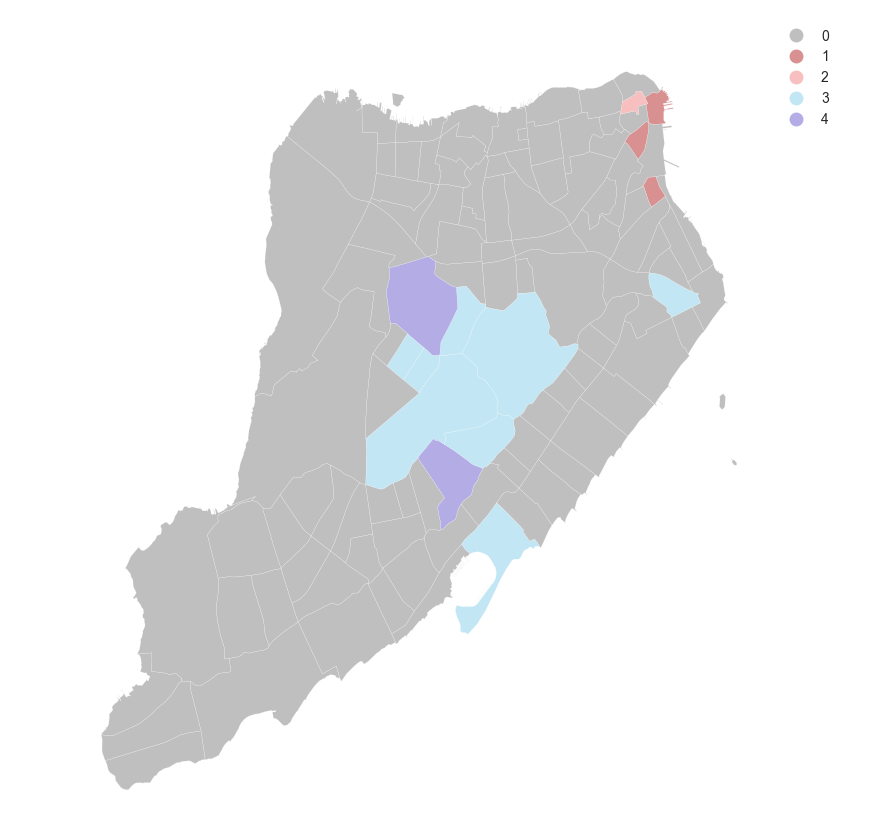

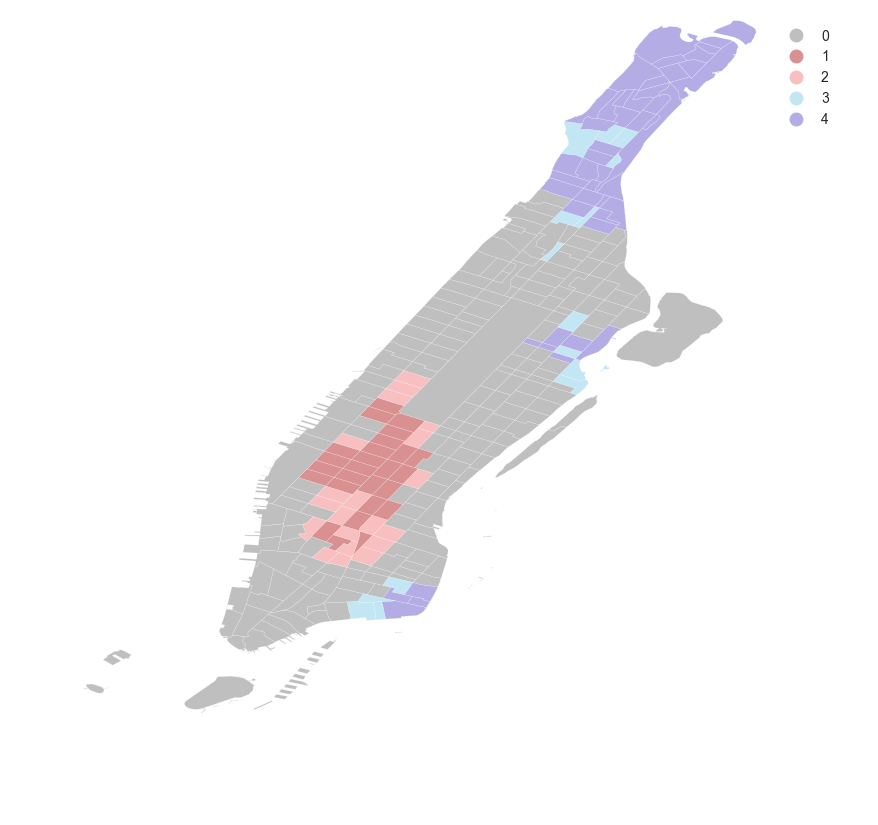

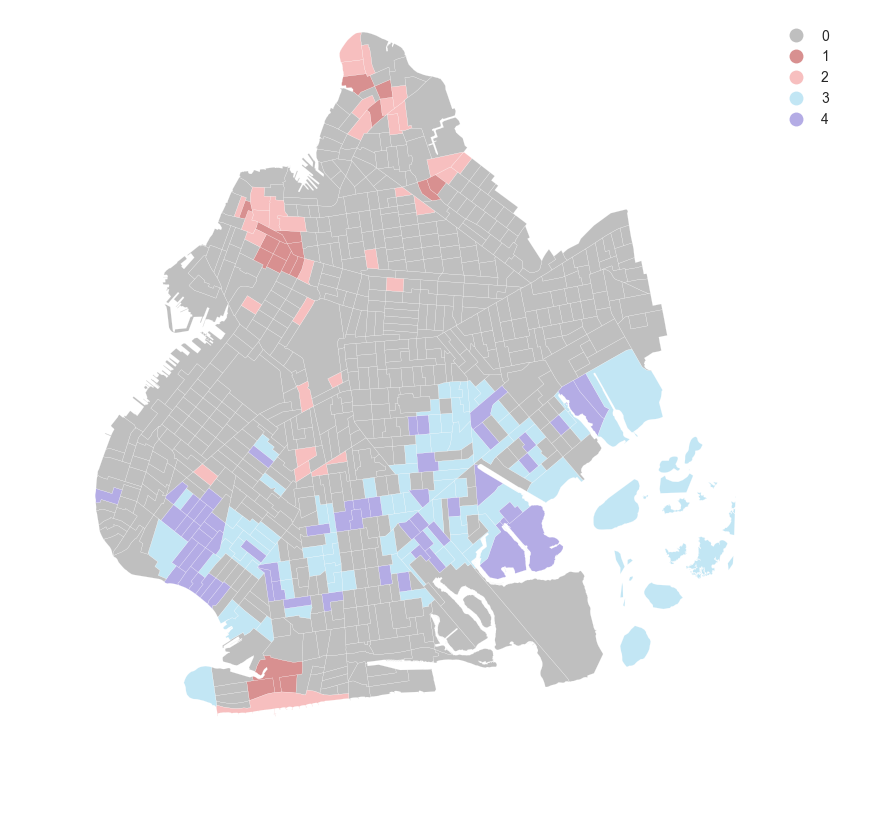

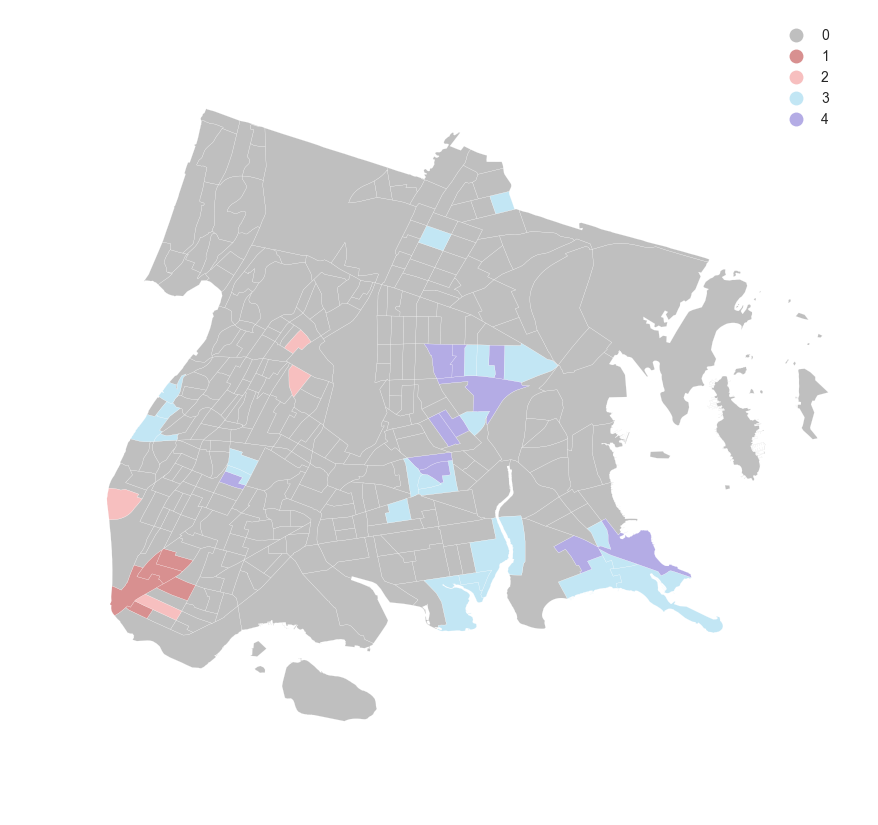

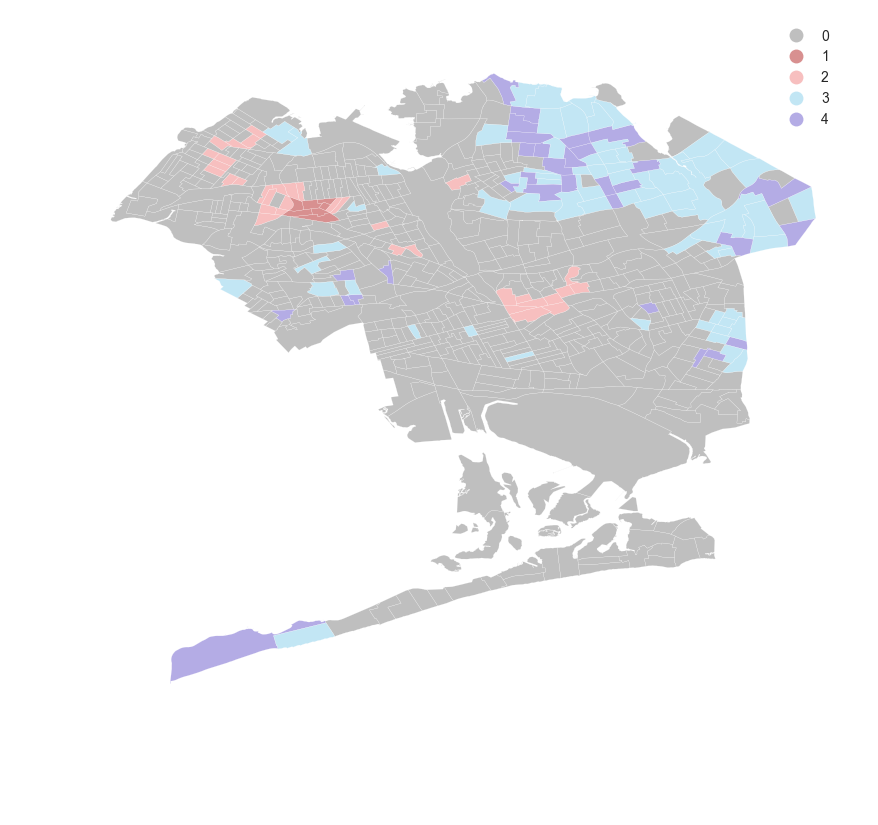

In [8]:
for boroname in boro:
    plotHotCold(boroname)